# **Wine Cellars Data Pipeline and Visualization Project**

---

<br>

**Author:** Cesar Hanna

**Date:** 02/01/20023

<br>

### **Index**
   [1. Project's Objectives](#1.-Project's-Objectives)
   
   [2. Scraping Program](#2.-Scraping-Program)
   
   [3. Data Storage Procedure](#3.-Data-Storage-Procedure)
   
   [4. Pipeline Architecture on Azure Synapse Analytics](#4.-Pipeline-Architecture-on-Azure-Synapse-Analytics)
   
   [5. Data Visualization With Power BI](#5.-Data-Visualization-With-Power-BI)
   
   [6. Closure](#6.-Closure)

<br>

#### **1. Project's Objectives**

As a wine enthusiast, it is sometimes difficult to look into wine information or data online to see what's new, get recommendations or simply for educational purposes. The reason for that is the sheer amount of data dispersed across many web pages which makes it very hard to browse and delve into the needed details.

Facing this challenge, I have decided to extract the data that I am looking for, organize it in a tabular form and eventually analyse it. Of course, going through thousands of web pages, extracting the data manually and loaded it into a table would be extremely time consuming, therefore, my approach is to create an automation that does this data extraction for me.

The next section will cover how this automation is developed.

<br>

#### **2. Scraping Program**

This section shows the detailed code that I've developed to scrape the data from 2 different sources.

The first source is scraping from "https://www.wine-searcher.com/critics-8-cellartracker?page=1" to get the scoring scale for each of the wine products; each product will have a scoring scale between 50 and 100 in which the intervals will be displayed in the dataset.

The second scraping source will be from "https://www.winemag.com/ratings/" in which the wine products fundamental data will be extracted.

A quick mention here that these 2 sources are one of the most reliable sources that the searched results have shown me.

Since the web page is dynamic (content is changing frequently), a standard or traditional way of scraping by just defining the XPATH or CSS and looping through the content will not work (already tried that :-)), so in order to mitigate this issue, the approach is to use a web-driver from the Selenium library.
Web-driver is a browser automation framework that works with open source APIs. The framework operates by accepting commands, sending those commands to a browser, and interacting with applications; before executing any requests, every browser has its own driver which initializes the web server.

**Installing the needed package(s) and importing the needed libraries to be used in the scraping procedure:**

In [4]:
# Importing the necessary libraries:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException

In [ ]:
!pip install webdriver_manager

**Scraping the Scoring Scale data and loading it into a dataframe:**

In [ ]:
# Scraping the scoring scale data:
webpage_scoring_scale = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
webpage_scoring_scale.get("https://www.wine-searcher.com/critics-8-cellartracker?page=1")
content_page = webpage_scoring_scale.page_source
result_scoring_scale = BeautifulSoup(content_page, 'html.parser')
prd_page1 = result_scoring_scale.find_all('div', {'class':'heading-sm'})

scoring_scale = []
for score_scale_item in prd_page1:
    score_scale_item.ul
    for item in score_scale_item.ul:
        scoring_scale.append(item.string)

for i in scoring_scale:
    if i == '\n':
        scoring_scale.remove(i)

In [27]:
# Creating the original dataframe for the scaling scale:
df_scoring_scale = pd.DataFrame(scoring_scale, columns=['Scoring_Scale'])
df_scoring_scale

,Scoring_Scale
0,98–100 – Extraordinary
1,94–97 – Outstanding
2,90–93 – Very good
3,86–89 – Good
4,80–85 – Average
5,70–79 – Below average
6,50–69 – Avoid


In [28]:
# Splitting the df_scoring_scale dataframe into 2 columns, 'Scoring' and 'Scale':
scoring = []
scale = []

for i in list(df_scoring_scale['Scoring_Scale']):
    rep = i.replace(i[6:], '')
    stp = rep.rstrip()
    scoring.append(stp)

for j in list(df_scoring_scale['Scoring_Scale']):
    rep = j.replace(j[:8], '')
    stp = rep.lstrip()
    scale.append(stp)

**Creating the final Scoring Scale dataframe:**

In [35]:
# Updating the scoring scale dataframe:
df_scoring_scale_updated = pd.DataFrame(zip(scoring, scale), columns=['Scoring', 'Scale'])
df_scoring_scale_updated

,Scoring,Scale
0,98–100,Extraordinary
1,94–97,Outstanding
2,90–93,Very good
3,86–89,Good
4,80–85,Average
5,70–79,Below average
6,50–69,Avoid


**Storing the dataframe on my local machine as CSV file:**

In [36]:
df_scoring_scale_updated.to_csv('C:\\Users\\cesar\\OneDrive\\Documents\\Cesar documents\\Data Science Projects\\Wine Ratings Analysis\\Dataset\\scoring-scale.csv', index=False)

**Scraping the main wine products data and loading it into an original dataframe:**

In [ ]:
# Creating and installing the webdriver using Selenium:
webpage = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

# Loading the initial webpage:
webpage.get("https://www.winemag.com/ratings/?s=&drink_type=wine&sort_by=pub_date_web&sort_dir=desc")

# Creating a counter for each page:
counter = 1

# Creating the lists that will hold the data scraped:
product_name = []
appellation = []
rating = []
price = []

# Scraping the first page:
content_first_page = webpage.page_source
result = BeautifulSoup(content_first_page, 'html.parser')
product_content = result.find_all('li', {'class': 'review-item'})

for item in product_content:
    product_name.append(item.h3.string)
    appellation.append(item.find('span', {'class': 'appellation'}))
    rating.append(item.find('span', {'class': 'rating'}))
    price.append(item.find('span', {'class': 'price'}))
      
# Loading the second page and waiting for 30 seconds until the scraping of the second page is done as per below:
WebDriverWait(webpage, 30).until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div/section/section/div[1]/div[1]/div[7]/section/div[3]/div/div/span[2]"))).click()
counter += 1

# Looping each page and scraping it:
while webpage.find_element(By.XPATH, '/html/body/div[1]/div/section/section/div[1]/div[1]/div[7]/section/div[3]/div/div/span[2]') and counter <= 1850:
    try:
        content = webpage.page_source
        result = BeautifulSoup(content, 'html.parser')
        product_content = result.find_all('li', {'class': 'review-item'})
        
        for item in product_content:
            product_name.append(item.h3.string)
            appellation.append(item.find('span', {'class': 'appellation'}))
            rating.append(item.find('span', {'class': 'rating'}))
            price.append(item.find('span', {'class': 'price'}))
    
        # Since the page is dynamic and has notifications poping-up, it is imperative to find the button and execute it; in this case a click of this button:
        next_button = webpage.find_element(By.XPATH, "/html/body/div[1]/div/section/section/div[1]/div[1]/div[7]/section/div[3]/div/div/span[2]")
        webpage.execute_script("arguments[0].click();", next_button)
        counter += 1
        time.sleep(5)
    except:
        print('Unexpected error occured on this page! Loading the next page...')
        next_button = webpage.find_element(By.XPATH, "/html/body/div[1]/div/section/section/div[1]/div[1]/div[7]/section/div[3]/div/div/span[2]")
        webpage.execute_script("arguments[0].click();", next_button)
        counter += 1

In [ ]:
# Checking the data in the 'product_name':
product_name

In [ ]:
# Appending the 'appellation' and printing the results:
appellation_list = []
for i in appellation:
    appellation_list.append(i.string)
    print(i.string)

In [ ]:
# Appending the 'rating' and printing the results:
rating_list = []
for i in rating:
    rating_list.append(i.strong.string)
    print(i.strong.string)

In [ ]:
# Appending the 'price_list' and printing the results:
price_list = []
for i in price:
    price_list.append(i.string)
    print(i.string)

In [14]:
df = pd.DataFrame(zip(product_name, appellation_list, rating_list, price_list), columns=['Product_Name', 'Appellation', 'Rating', 'Price' ])
df

,Product_Name,Appellation,Rating,Price
0,Charles Heidsieck NV Champagne Charlie Brut (...,Champagne,100,$700
1,Stag's Leap Wine Cellars 2019 Fay Estate Grown...,Napa,100,$155
2,Marqués de Riscal 2016 150 Aniversario Gran Re...,Northern Spain,99,$60
3,Salon 2012 Le Mesnil Blanc de Blancs Brut Char...,Champagne,99,$992
4,Philipponnat 2013 Clos des Goisses Extra Brut ...,Champagne,99,$320
...,...,...,...,...
11099,Bodegas Franco-Españolas 2016 Royal Reserva Te...,Northern Spain,92,$45
11100,Cedarville 2019 Estate Grenache (El Dorado),Sierra Foothills,92,$36
11101,Doña Paula 2018 Alluvia Parcel Bush Vines Malb...,Mendoza Province,92,$100
11102,El Enemigo 2017 Gran Enemigo El Cepillo Single...,Mendoza Province,92,$100


**Storing the oroginal wine products dataframe on my local machine as a CSV file:**

In [17]:
df.to_csv("C:\\Users\\cesar\\OneDrive\\Documents\\Cesar documents\\Data Science Projects\\Wine Ratings Analysis\\Dataset\\wine-data.csv", index=False)

<br>

#### **3. Data Storage Procedure**

**Uploading the csv file into Azure Blob Storage**

In [ ]:
!pip install azure-storage-blob

In [2]:
from azure.storage.blob import BlobServiceClient

In [5]:
# Reading the csv file into a pandas dataframe:
csv_df = pd.read_csv('C:\\Users\\cesar\\OneDrive\\Documents\\Cesar documents\\Data Science Projects\\Wine Ratings Analysis\\Dataset\\wine-data.csv')

# Creating a string object that holds the converted pandas dataframe into a csv:
csv_file = csv_df.to_csv(index=False, encoding='utf-8')

In [ ]:
# Creating the blob service object in order to connect to Azure Blob Storage:
blob_service = BlobServiceClient.from_connection_string(
   "DefaultEndpointsProtocol=https;AccountName=**********;AccountKey=***********;EndpointSuffix=core.windows.net")

# Defining the container and the blob that we want to create inside the container: 
container_client = blob_service.get_container_client('datacontainer')
blob_client = blob_service.get_blob_client(container='datacontainer', blob='wine-data.csv') 

# Uploading the csv_file object as csv into Azure Blob Storage:
blob_client.upload_blob(csv_file, blob_type="BlockBlob")

<br>

#### **4. Pipeline Architecture on Azure Synapse Analytics**

After the data storage automation into Azure Blob Storage is complete, it is time now to create the pipeline that will perform the **ETL (Extract, Transform, Load)** procedure in order to make the data ready for visualization and analysis.

For that, I have created the pipeline in Azure Synapse Analytics where I ingested the data from the Azure Blob Storage using the 'Copy data' activity, transformed it using 'Data flow' activity and eventually sunk it into the Dedicated SQL Pool that I created in Azure Synapse Analytics.

The following architecures illustrate the procedure flow; the first image shows a high level overview and the second image shows a more detailed one.

**High Level Architecture Overview:**

*Please open the picture in a new tab or download it in order to see it full size*

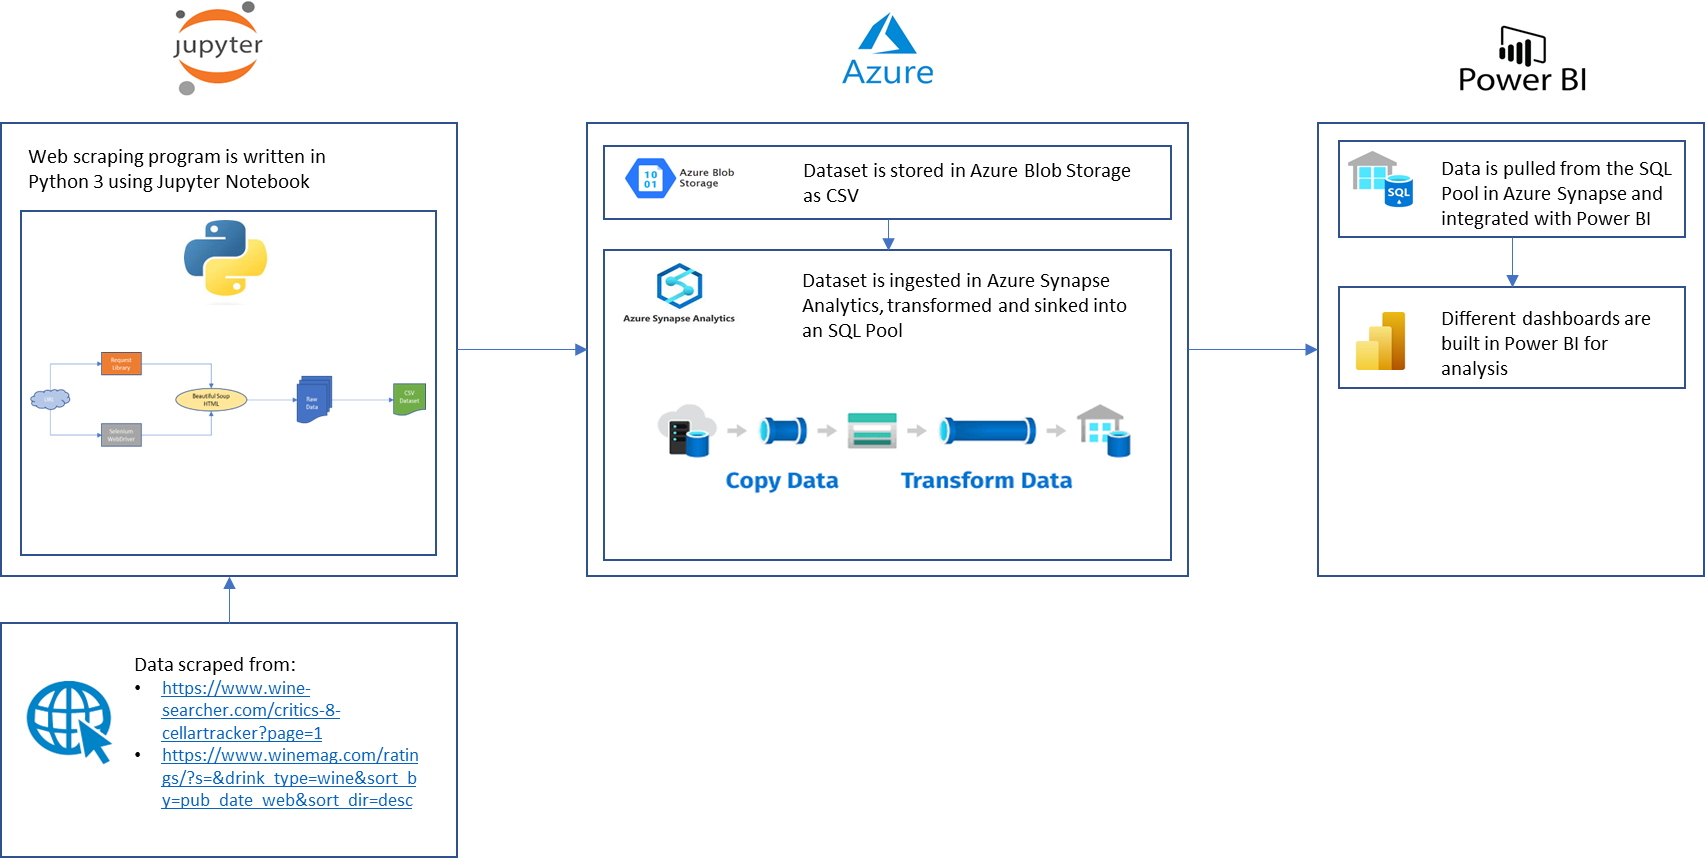

**A More Detailed Overview:**

*Please open the picture in a new tab or download it in order to see it full size*

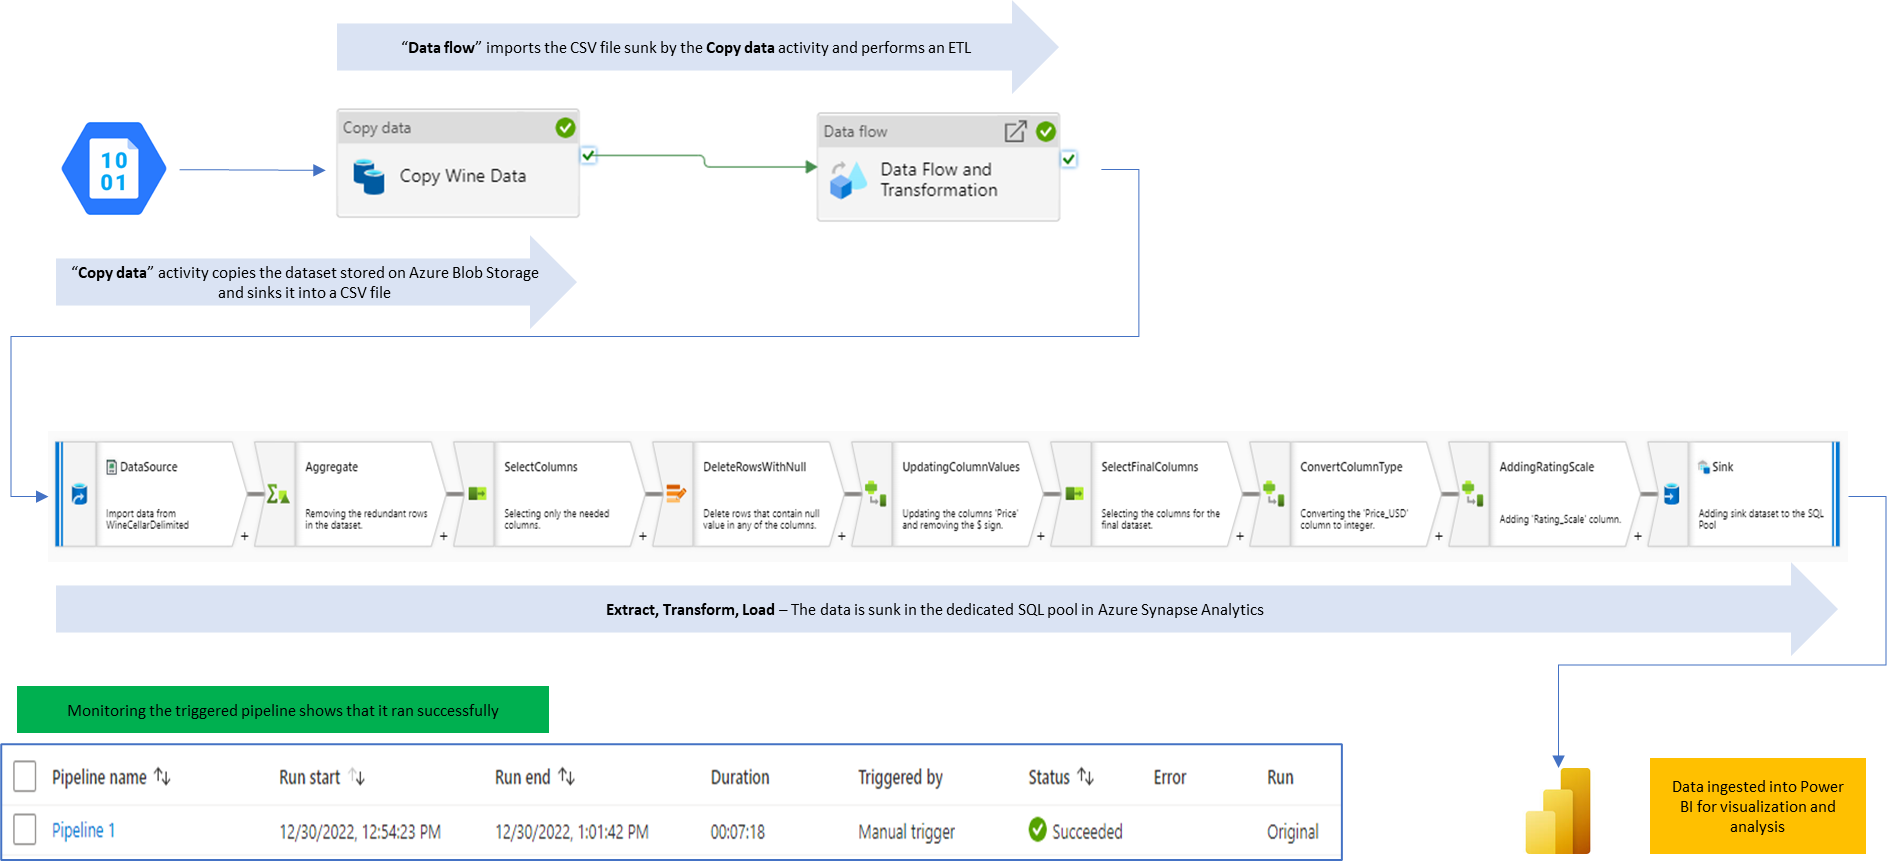

Breakdown description on each activity within the ETL pipeline:

* **DataSource:** this activity imports the ingested CSV file done by the "Copy data" activity for it to be ready for transformation.
* **Aggregate** this activity is used to remove the redundant records in the dataset by aggregating all the columns/fields. A count() aggregate function is used in this case.
* **SelectColumns:** here we are selecting only the needed columns; in this case we are selecting all the columns expect for the count column created by the aggregation function in the previous activity.
* **DeleteRowsWithNull:** as the name indicates, this activity deletes all the records that have 'NULL' as values no matter in which column.
* **UpdatingColumnValues:** here I am removing the $ sign from the 'Price' column as this will impact the visualization later on by creating a new column with the name 'Price_USD' entailing the prices without a currency sign, to indicate that the prices are in US dollars.
* **SelectFinalColumns:** in this activity I am selecting the all the columns except for the 'Price' column which is replaced by 'Price_USD'.
* **ConvertColumnType:** here I am converting the column type of 'Price_USD' to integer.
* **AddingRatingScale:** as shown in the Scoring Scale dataset in section 2 for each interval of scoring, this activity will create a new column called 'Rating_Scale' where the scaling values are populated following the condition of the scoring interval.
* **Sink:** finally, this activity will sink the final dataset created in the previous activity into the Dedicated SQL Pool in Azure Synapse Analytics. Note that this activity will only work after the table is created within the SQL Pool, and this case I created the table in the database under the name 'wine-products' within the 'dbo' schema.

The pipeline is triggered at the end and the monitoring shows a successfull execution. In addition, I have used a '**SELECT * FROM wine-products**' query in the SQL Pool and all the dataset records show in the table correctly.

<br>

#### **5. Data Visualization With Power BI**

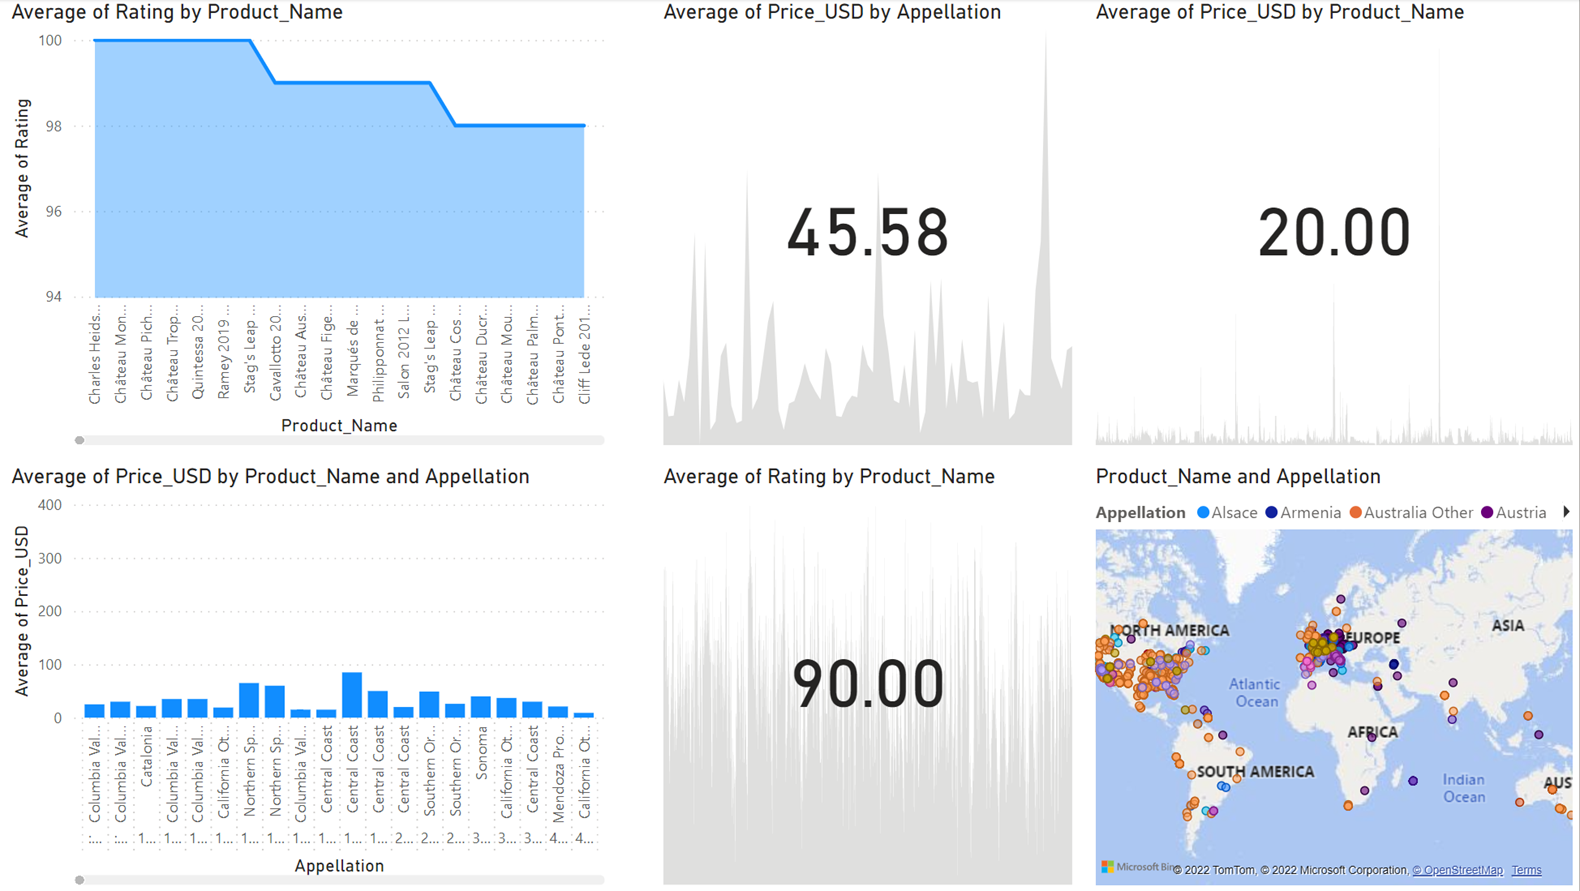

As shown in the visualization, the 'Average' of Rating and Price_USD by Product_Name and Appellation is the focus, in addition to the geographical locations of these wine cellars. Further visualization can be created by just manipulating the data dimensions in the SQL Pool.

The way to connect to the database is simply by selecting **Azure Synapse Analytics** in Power BI, authenticate with the databse by entering the credentials (username and password in this case) and voila! you are connected.

<br>

#### **6. Closure**

I was able to successfully create an end to end flow by automating the creation of data, its transformation and analysis using a combination of Python programing, Azure pipeline and SQL queries in the dedicated SQL Pool.

As mentioned in the previous section, there could be way more analytics applied in this project, just by creating different dimensions in the SQL database, however, this is not the main objective here.